# Exploring expectiles

In [1]:
import numpy as np
import scipy.stats as stats
import scipy.optimize as opt
import scipy.io
import matplotlib.pyplot as plt
import matplotlib.style as style; style.use('ggplot')

from gmm import EXAMPLE
from expectiles import expectile

## Example distribution

We'll want an example multi-modal distribution to play around with.

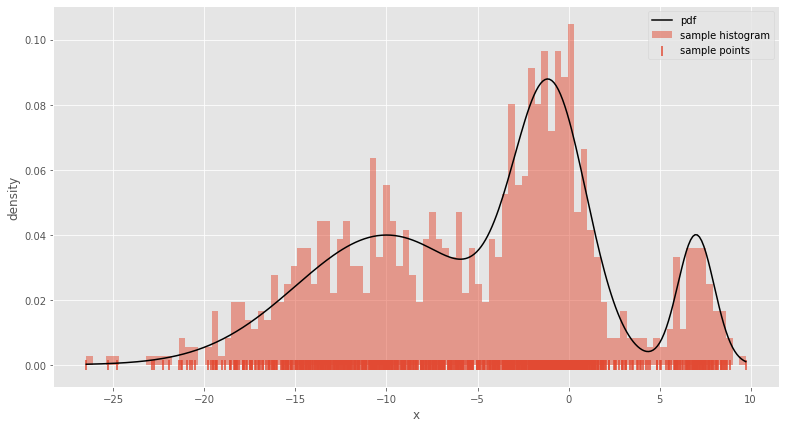

In [2]:
SAMPLE, GMM_X, GMM_Y = EXAMPLE(1000)

## Plotting expectiles

We can show the expeciles as vertical bars on a histogram, or we can plot the expectiles of a distribution as a function of $\tau \in [0, 1]$.

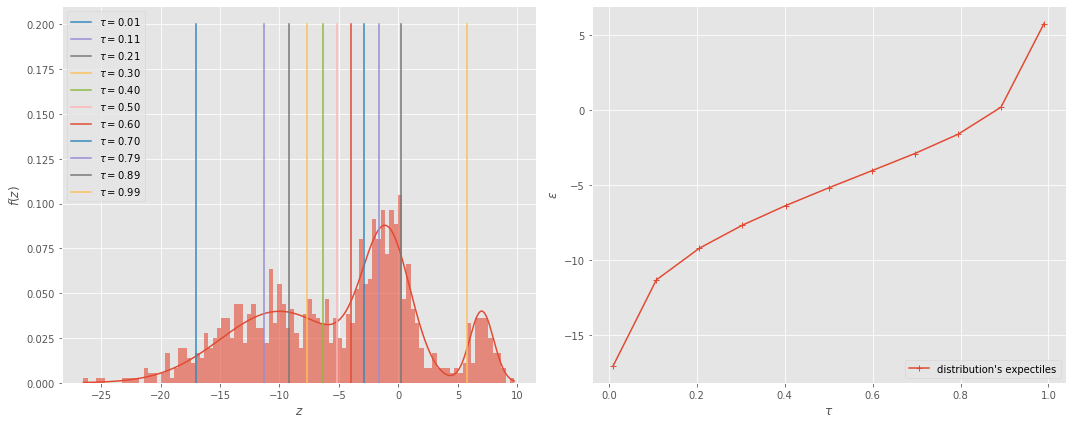

In [3]:
taus = np.linspace(0.01, 0.99, 11)
epss = expectile(SAMPLE, taus)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

ax1.plot(GMM_X, GMM_Y)
ax1.set_prop_cycle(None)
ax1.hist(SAMPLE, density=1, alpha=0.6, bins=100)
for tau, eps in zip(taus, epss):
    ax1.plot([eps, eps], [0, 0.2], label=f"$\\tau={tau:.2f}$")

ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

ax2.plot(taus, epss, marker='+', label='distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

## Imputing expectiles

*Imputation* is the process of 'reconstructing' a distribution given a set of expectiles, so that the distribution has those same expectiles.

Formally, given $\tau_i$ and $\epsilon_{\tau_i}$ for $i = 1, \ldots, K$, we seek a distribution $\eta$ such that for all $i \in \{1,\ldots,K\}$, $\epsilon_{\tau_i} = \text{arg min}_\epsilon ER(\epsilon; \eta, \tau_i)$.

Equivalently, we require that $\frac{\partial}{\partial\epsilon} ER(\epsilon; \eta, \tau_i) |_{\epsilon=\epsilon_{\tau_i}} = 0$ (for all $i \in \{1,\ldots,K\}$), or, framed as an optimisation problem over $\eta$, that

$$
\eta
\in
\text{arg min}_\eta
    \sum_{i=1}^K
    \left(
        \frac{\partial}{\partial\epsilon}
        ER(\epsilon; \eta, \tau_i)
        |_{\epsilon=\epsilon_{\tau_i}}
    \right)^2
$$

Note that given any finite set of expectiles, there may be multiple distributions satisfying the constraints given by those expectiles. We will be satisfied with any such distribution.

In particular, if we assume that the distribution is an empirical distribution on $N$ sample points $z_1, \ldots, z_N$ (with $\eta = \sum_{i=1}^{N} \frac{1}{N} \delta_{z_i}$) then the problem is convex and 'particularly tractable', according to the DeepMind paper (their stochastic expetile distributional reinforcement learning algorithm uses $N=K$ and a default scipy optimiser to solve the problem).

In [4]:
def ER_loss(eps, tau, sample):
    n = len(sample)
    above_loss = 1/n * np.sum(np.square(sample[sample  > eps] - eps))
    below_loss = 1/n * np.sum(np.square(sample[sample <= eps] - eps))
    return tau * above_loss + (1-tau) * below_loss
def grad_eps_half_ER_loss(eps, tau, sample):
    n = len(sample)
    above_grad_loss = 1/n * np.sum(eps - sample[sample  > eps])
    below_grad_loss = 1/n * np.sum(eps - sample[sample <= eps])
    return tau * above_grad_loss + (1-tau) * below_grad_loss
# TODO: I think I could make this more direct using the same kinds of ideas
# as above for the direct computation of the expectiles, and it should
# improve the efficiency of the optimisation process...!

def impute(taus, epss, n, method='min', start='uniform'):
    tes = np.array(list(zip(taus, epss)))

    if start == 'uniform':
        # initialise as uniform distribution between most
        # extreme expectiles
        z0 = np.linspace(epss[0], epss[-1], n)
    elif start == 'bestof1000':
        # this is implemented for 2020 paper to
        # 'significantly improve optimum found'
        # (note: they also repeat this 10 times)
        zs = np.random.uniform(epss[0], epss[-1], (1000, n))
        z0 = zs[np.argmin([sum(ER_loss(eps, t, z) for t, e in zip(taus, epss)) for z in zs])]
    if method=='root':
        k = len(tes)
        if n != k:
            raise Exception("Hey! This method requires n=k (number of expectiles)")
        def eps_gradient(sample):
            grad = np.zeros(n)
            grad[:k] = [grad_eps_half_ER_loss(e, t, sample) for t, e in tes]
            return grad
        return opt.root(eps_gradient, x0=z0).x
    elif method=='min':
        def sum_square_grads(sample):
            return sum(grad_eps_half_ER_loss(e, t, sample)**2 for t, e in tes)
        return opt.minimize(sum_square_grads, x0=z0).x

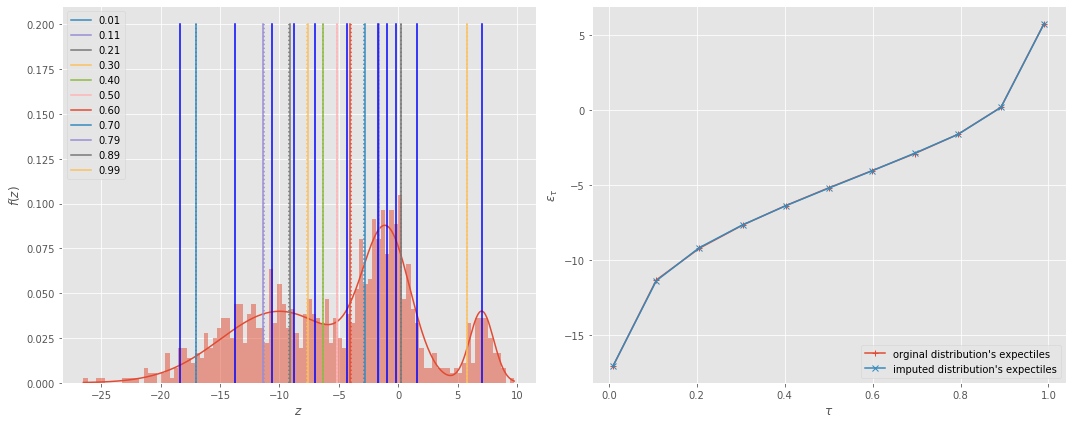

In [5]:
# compute and impute
taus = np.linspace(0.01, 0.99, 11)
epss = expectile(SAMPLE, taus)
imputed_sample = impute(taus, epss, n=len(taus), method='root', start='bestof1000')
imputed_expectiles = expectile(imputed_sample, taus)

# plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# original sample and expectiles

ax1.set_prop_cycle(None)
ax1.hist(SAMPLE, density=1, alpha=0.5, bins=100)
for t, e in zip(taus, epss):
    ax1.plot([e, e], [0, 0.2], linestyle=':')
# new expectiles
ax1.set_prop_cycle(None)
ax1.plot(GMM_X, GMM_Y)
for t, e in zip(taus, imputed_expectiles):
    ax1.plot([e, e], [0, 0.2], label=f"{t:.2f}")
# new sample
for z in imputed_sample:
    ax1.plot([z, z], [0, 0.2], color='blue')
ax1.set_xlabel("$z$")
ax1.set_ylabel("$f(z)$")
ax1.legend(loc="upper left")

# expectiles plot
ax2.plot(taus, epss, marker='+', label='orginal distribution\'s expectiles')
ax2.plot(taus, imputed_expectiles, marker='x', label='imputed distribution\'s expectiles')
ax2.set_xlabel(r'$\tau$')
ax2.set_ylabel(r'$\epsilon_\tau$')
ax2.legend(loc="lower right")

plt.tight_layout()
plt.show()

In [6]:
def compute_and_impute(taus, sample=SAMPLE, n=None, method='min', start='bestof1000'):
    if n is None: n = len(taus)

    # compute
    epss = expectile(sample, taus)
    
    # impute
    imp_samp = impute(taus, epss, n=n, method=method, start=start)
    imp_epss = expectile(imp_samp, taus)

    # plot results:
    # histogram of original sample:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(13, 6))
    ax1.hist(sample, density=1, alpha=0.5, bins=100, label="original distribution")
    # imputed sample points:
    for z in imp_samp:
        ax1.plot([z, z], [0, 0.01], color='blue')    
    # gaussian-KDE-smoothed imputed sample distribution:
    imp_dist = stats.gaussian_kde(imp_samp, bw_method=0.2)
    imp_support = np.linspace(min(np.min(sample), np.min(imp_samp)), 
                              max(np.max(sample), np.max(imp_samp)))
    ax1.plot(imp_support, imp_dist.pdf(imp_support), label="imputed distribution (smoothed)")


    ax1.set_xlabel("$z$")
    ax1.set_ylabel("$f(z)$")
    ax1.legend(loc="upper left")

    # expectile comparison plot
    full_taus = np.linspace(0.01, 0.99, 99)
    full_epss_old = expectile(sample, full_taus)
    full_epss_new = expectile(imp_samp, full_taus)
    ax2.plot(full_taus, full_epss_old, label='orginal distribution\'s expectiles')
    ax2.plot(full_taus, full_epss_new,  label='imputed distribution\'s expectiles')
    ax2.scatter(taus, epss, marker='+')
    ax2.scatter(taus, imp_epss, marker='x')
    ax2.set_xlabel(r'$\tau$')
    ax2.set_ylabel(r'$\epsilon_\tau$')
    ax2.legend(loc="lower right")

    plt.tight_layout()
    plt.show()

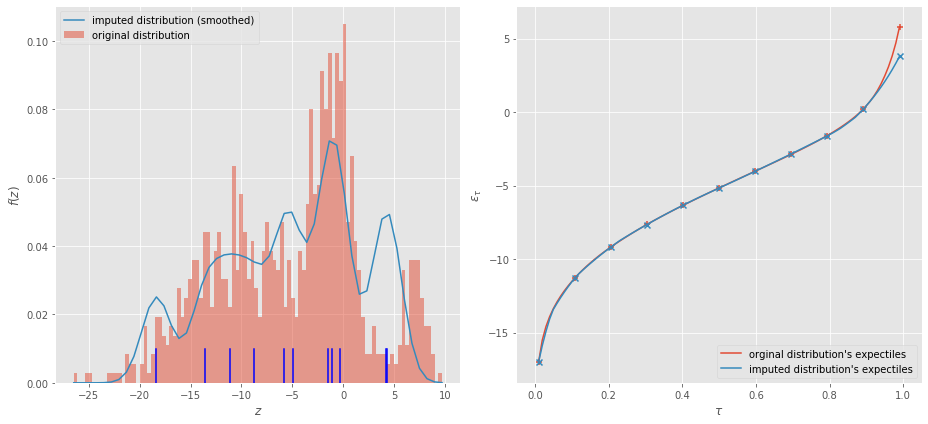

In [7]:
compute_and_impute(taus=np.linspace(0.01, 0.99, 11))

## Playing with the taus

What effect does changing the distribution of expectile biases have on the recovered distribution?

Here I'll use the previously developed sample and imputation methods along with gaussian KDE-smoothing to explore the effect of the tau range on the recovered distribution.

#### What if we nuke the optimistic (or pessimistic) taus?

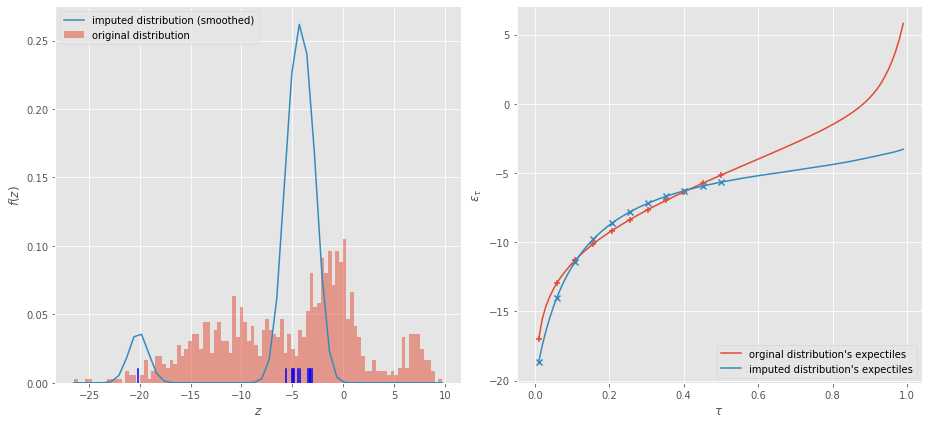

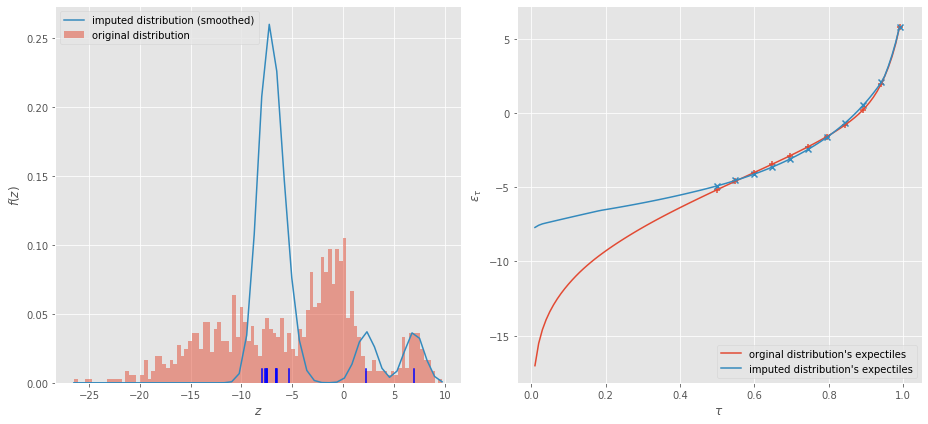

In [19]:
compute_and_impute(taus=np.linspace(0.01, 0.50, 11))
compute_and_impute(taus=np.linspace(0.50, 0.99, 11))

Seems like we struggle to reconstruct a broad distribution, with notable lack of fidelity on the nuked side. What would be the effect on prediction of these distributions?

### What if we restrict the range tightly around the mean?

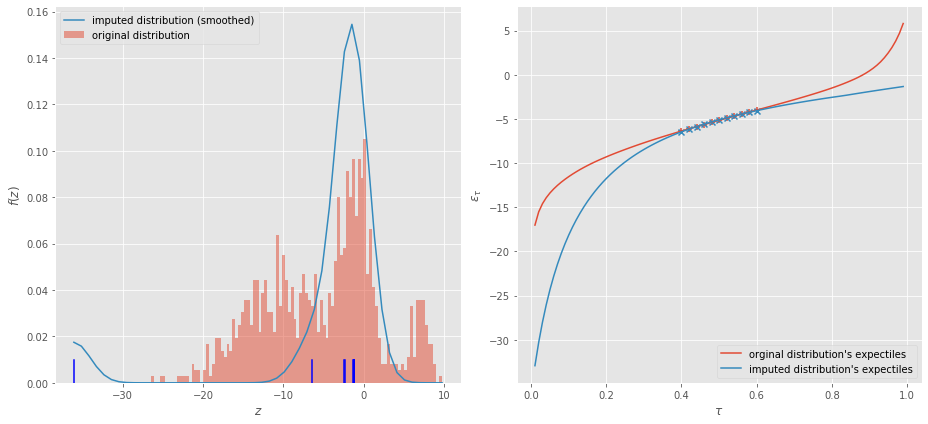

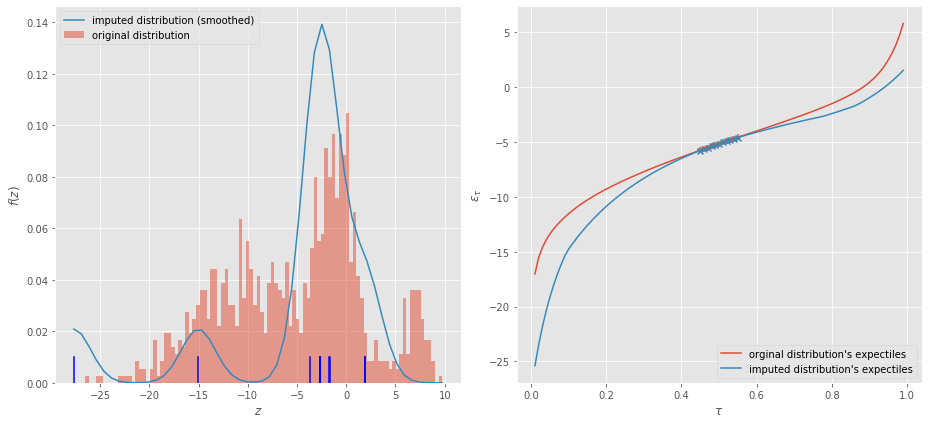

In [20]:
compute_and_impute(taus=np.linspace(0.40, 0.60, 11))
compute_and_impute(taus=np.linspace(0.45, 0.55, 11))

The effect isn't so bad. Well, in the limit, we should recover the mean of the distribution, which was good enough to be state-of-the-art in reinforcement learning until a few years ago!

### What if we use a tight range not including the mean?

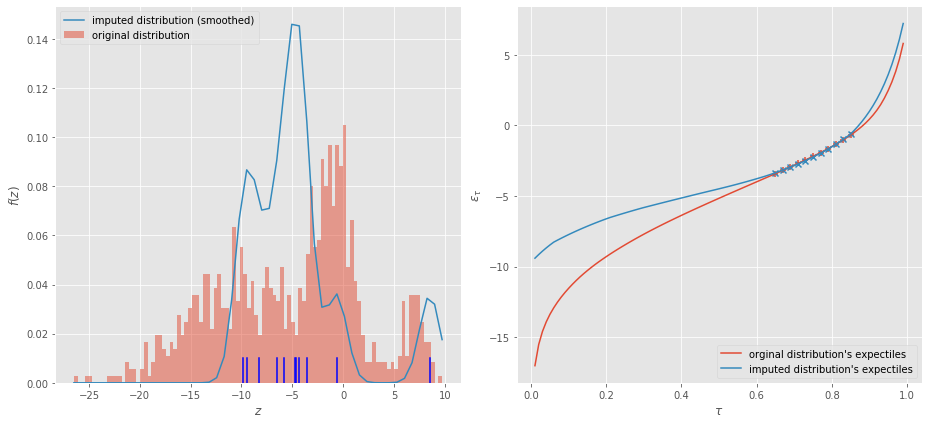

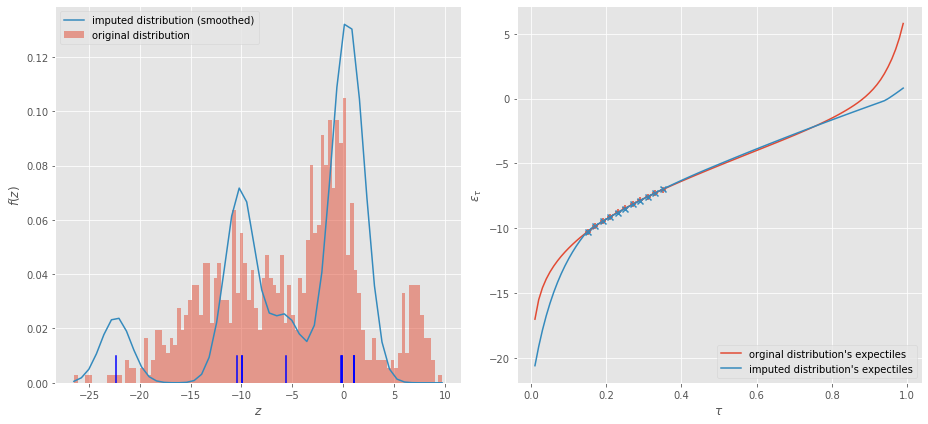

In [21]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 11))
compute_and_impute(taus=np.linspace(0.15, 0.35, 11))

It's like half-way between the other two types.

Notably, it seems that in all cases, we still do a pretty great job of recovering all of the expectiles we kept (how would we go with the ones we didn't keep?).

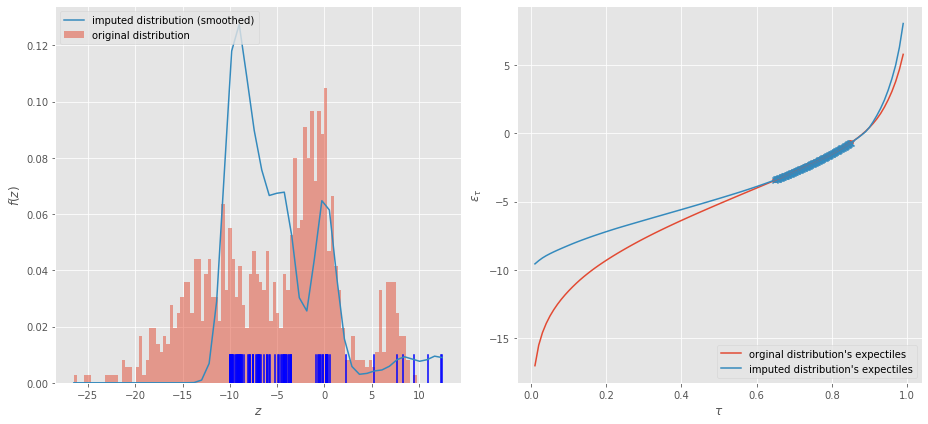

In [17]:
compute_and_impute(taus=np.linspace(0.65, 0.85, 100))

## Neural data

The deepmind nature paper came with the following neural recording data of optogenetically-modified mouse VTA neurons from a variable-magnitude-reward task (see the paper).

It appears to be a list of **reversal point**, **assymetric scaling** pairs (one per neuron).

* **Reversal point**: The reward amount at which the neuron will switch from eliciing a negative response to a positive response. This is understood to have been be calibrated to a particular expectile of the distribution, after the animals learned the task. Reward magnitudes are in 'estimated utility space' (see paper, methods section).
* **Asymmetric scalings**: The relative magnitude of positive RPE signals and negative RPE signals, $\alpha_+ / (\alpha_+ + \alpha_-)$, estimated for each neuron from response data (by separately estimating the gradient of the response slope for different rewards above and below the reversal point).

In [9]:
# BEGIN DEEP MIND DATA DUMP
# Estimated reversal points and asymmetric scalings from neural recordings
var_mag_values = np.array([(0.14723085014789711, 0.0033614698516132471),
                            (0.28667599774228614, 0.021082047404663212),
                            (0.28748251623549403, 0.049914307764483815),
                            (0.92369323024116956, 0.24368197348648254),
                            (1.3480737534396756, 0.42196866227890156),
                            (1.4125829520026296, 0.2235311630494646),
                            (1.6045034820863808, 0.47702076606215371),
                            (1.7501708044381341, 0.29611582067273567),
                            (3.2848767728849375, 0.3618169272255663),
                            (3.5349203217064185, 0.44251699585808746),
                            (3.7255198380895553, 0.51354237852028162),
                            (4.0160347355202095, 0.29136286695651709),
                            (4.1701645396832827, 0.24596278464602545),
                            (4.3778473672540272, 0.3389597335165157),
                            (4.3819834616604236, 0.4109029572142629),
                            (4.4271922132492669, 0.54775816343621309),
                            (4.5687396324777776, 0.22381550301577841),
                            (4.7432185053035987, 0.98442343982467528),
                            (4.8867786789047276, 0.53931528154401065),
                            (5.1465509369647409, 0.41450775685564373),
                            (5.1545083160041001, 0.56729757738255948),
                            (5.3809271892982986, 0.58246691207675527),
                            (5.4864699584151664, 0.68976626445596256),
                            (5.5322519651782756, 0.34638864585759571),
                            (5.8339188805237727, 0.55480031389511075),
                            (6.2720723207776592, 0.55707650132171915),
                            (6.440584024346915, 0.66221660546254524),
                            (6.5887100296960242, 0.71219295412779748),
                            (6.6818030225629439, 0.65433601123932617),
                            (6.8779347387975447, 0.79852221439758531),
                            (7.8087442676123002, 0.75769015692609276),
                            (8.1264758131781729, 0.70370061384230076),
                            (9.1472582490193517, 0.73113239691022691),
                            (10.202846417424675, 0.63879297718190153),
                            (10.234208410480866, 0.66074850653214368),
                            (10.502672664775268, 0.68294063333022759),
                            (11.277139094915993, 0.7518787167727442),
                            (12.894339210279924, 0.80620103870695436),
                            (13.779164335318981, 0.67485657176374936),
                            (20.0, 0.95602078106395083)])
# END DEEP MIND DATA DUMP

Now, we know these concepts as '$\epsilon_\tau$' and '$\tau$', respectively. So, we have a list of expectiles and taus based on the hypothetical learned reward distribution.

Let's play!

In [11]:
neural_data = var_mag_values
neural_epss, neural_taus = neural_data.T

In [28]:
print("no. neurons:", len(neural_data))

no. neurons: 40


That's the same as in the paper 😅.

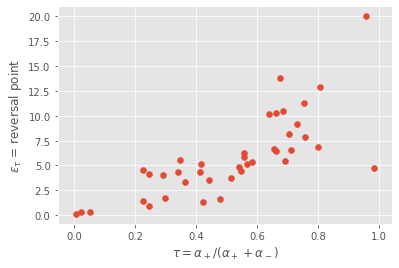

In [15]:
# The tau-expectile plot:
plt.scatter(neural_taus, neural_epss)
plt.ylabel(r"$\epsilon_\tau$ = reversal point")
plt.xlabel(r"$\tau = \alpha_+ / (\alpha_++\alpha_-)$")
plt.show()

Looks similar-*ish* to the plot in the paper (figure **4d**). However, they 1) included curves learned from the ground truth distribution in simulation, and 2) seem to have excluded the top point (it's quite high, and it showed an even higher error bar in figure **4c**).

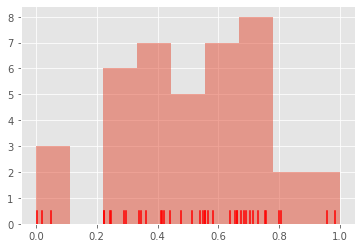

In [14]:
# expectile diversity:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.5], color="red")
plt.show()

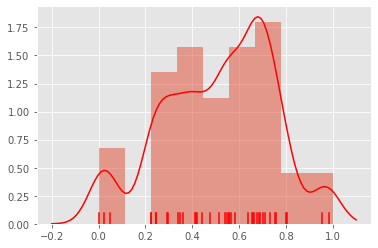

In [13]:
# same PLUS a gaussian-KDE-smoothed version:
plt.hist(neural_taus, bins=np.linspace(0, 1, 10), density=True, alpha=0.5)
for tau in neural_taus:
    plt.plot([tau, tau], [0, 0.1], color="red")
kde_dist = stats.gaussian_kde(neural_taus, bw_method=0.25)
support  = np.linspace(-0.2, 1.1, 100)
plt.plot(support, kde_dist.pdf(support), color="red", label="smoothed distribution (kde bw=0.2)")
plt.show()

Note: KDE probably not appropriate, given that the values are actually only supported over [0, 1] (as probabilities).

Anyway, I wonder where THIS distribution has come from? It doesn't look particularly clean: too centralised to be uniform (?), too spread to be Gaussian (?)

Note: you can't really tell what distribution a sample is from just by eyeballing it: do a statistical test! and for that, this is a very small sample.

What about the inverse logistic function of the biases? This might be sensibly distributed, since it corresponds to the biases arising according to the logistic function, which seems like a reasonable way to produce these asymmetries.

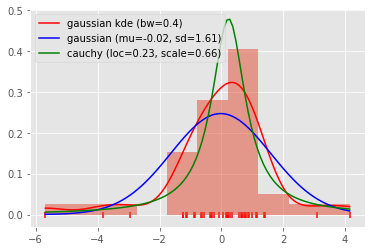

In [17]:
neural_logits = np.log(neural_taus / (1 - neural_taus))
plt.hist(neural_logits, density=True, alpha=0.5)
plt.scatter(neural_logits, np.zeros_like(neural_taus), color='red', marker='|')

# overlay some curves
support  = np.linspace(neural_logits.min(), neural_logits.max(), 100)

# gaussian kde
bw = 0.4
kde_dist = stats.gaussian_kde(neural_logits, bw_method=bw)
plt.plot(support, kde_dist.pdf(support), color="red", label=f"gaussian kde ({bw=})")

# single gaussian
norm_fit = stats.norm.fit(neural_logits)
norm_dist = stats.norm(*norm_fit)
plt.plot(support, norm_dist.pdf(support), color="blue",
         label="gaussian (mu={:.2f}, sd={:.2f})".format(*norm_fit))

# cauchy dist (heavy tails)
cauchy_fit = stats.cauchy.fit(neural_logits)
cauchy_dist = stats.cauchy(*cauchy_fit)
plt.plot(support, cauchy_dist.pdf(support), color="green",
         label="cauchy (loc={:.2f}, scale={:.2f})".format(*cauchy_fit))

plt.legend()
plt.show()

Neither of these (cauchy, gaussian) looks like a particularly great fit. Maybe some statistical tests could make that claim more rigorous. But this would imply that the balances are/are-not distributed in these ways.

### Recovering the distribution

How does this distribution go for OUR sample/reward distribution?

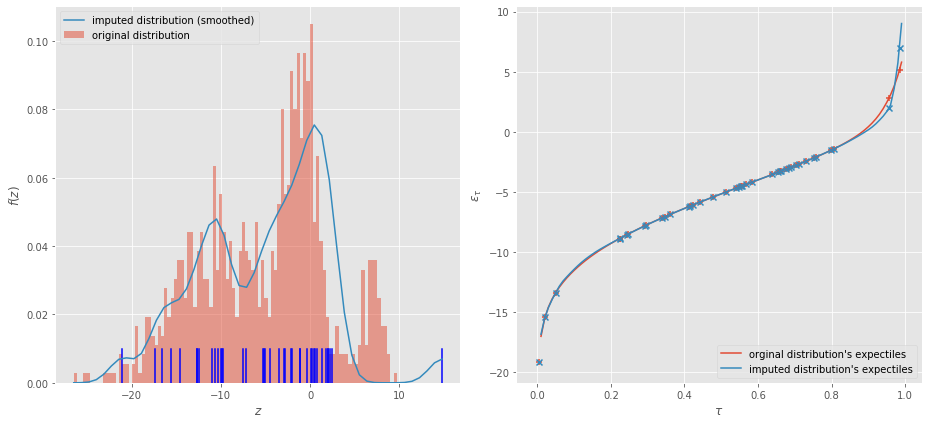

In [18]:
compute_and_impute(taus=neural_taus)

Answer: Spot on! Nails it. However, fewer expectiles probaly would have done the trick too. Come to think of it, there are obviously more than 40 RPE-learning + signaling neurons in a brain. So, it's really just the distribution which matters.

## Signalling RPEs

The hypothesis goes that these 'neurons' are responsible for calculating and signalling RPEs. The response is determined by the positive or negative rate and the reversal point. I expect that the average response will matter for downstream learning (maybe this is not the case, and downstream neurons tune in to signals of a particular asymmety for some reason...?). If so, it will be a weighted average according to the asymmetry distribution. Let's investigate how this signal varies in response to the magnitude of a reward!

In [22]:
def rpe_signal_spectrum(taus, sample, base_learn_rate=0.01):
    taus = np.array(taus)
    epss = np.array(expectile(sample, taus))

    learn_rate_factors = np.sqrt(taus/(1-taus))
    # note: here I am including assumptions about how
    # the learning rates are distributed about a base
    # rate. could use some actual neural data...?
    neg_learn_rates = base_learn_rate / learn_rate_factors
    pos_learn_rates = base_learn_rate * learn_rate_factors
    
    rewards = np.linspace(np.min(sample), np.max(sample), 100)
    responses = np.zeros((100, taus.size))
    for i, x in enumerate(rewards):
        # decide learn rates for each neuron (based on whether
        # signal is above or below expectation)
        learn_rates = neg_learn_rates.copy()
        pos_err = np.where(x > epss)
        learn_rates[pos_err] = pos_learn_rates[pos_err]
        # these determine the response
        responses[i] = learn_rates * (x - epss)
        
    means_response = base_learn_rate * (rewards - np.mean(sample))
    
    plt.fill_between(rewards, responses.max(axis=1), responses.min(axis=1),
            color="gray", alpha=0.5, label="individual neuron responses")
    for j in range(epss.size):
        plt.plot(rewards, responses[:, j], alpha=0.5, color="gray")
    plt.plot(rewards, np.mean(responses, axis=1), linewidth=3,
             label="mean response of all neurons")
    plt.plot(rewards, means_response, linewidth=3,
             label=r"response of $\tau=0.5$ neuron")
    plt.xlabel("reward")
    plt.ylabel("response (reward prediction error)")
    plt.legend()

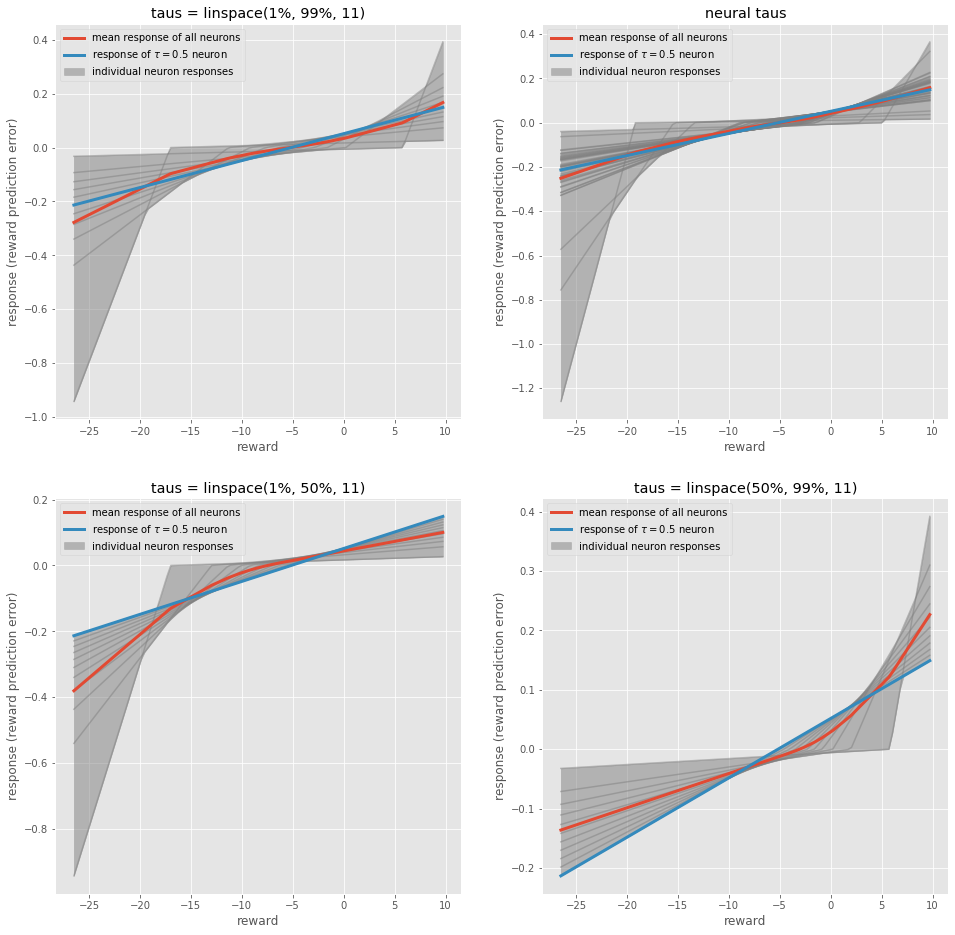

In [23]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 16))

ax1.set_title("taus = linspace(1%, 99%, 11)")
plt.sca(ax1)
rpe_signal_spectrum(np.linspace(0.01, 0.99, 11), SAMPLE)

ax2.set_title("neural taus")
plt.sca(ax2)
rpe_signal_spectrum(neural_taus, SAMPLE)

ax3.set_title("taus = linspace(1%, 50%, 11)")
plt.sca(ax3)
rpe_signal_spectrum(np.linspace(0.01, 0.5, 11), SAMPLE)

ax4.set_title("taus = linspace(50%, 99%, 11)")
plt.sca(ax4)
rpe_signal_spectrum(np.linspace(0.5, 0.99, 11), SAMPLE)

plt.show()

## Naming asymmetries

$\epsilon$s are 'expectiles', what is a good word for describing the $\tau$s?

Whatever the choice, it should recover the following meanings:

* $\tau=0.5$ implies a 'balanced' expectile,
* $\tau > 0.5$ implies an 'optimistic' expectile,
* $\tau < 0.5$ implies a 'pessimistic' expectile.

### The word

The deepmind paper calls $\tau$ an 'asymetric scaling', or 'asymetric scaling ratio', referring to $\tau = \alpha_+ / (\alpha_+ + \alpha_-)$, where $\alpha$s are 'scalings' (learning rates). They refer to a 'diversity of expectiles' rather than a diversity in expectile-parameters. In the supplemental information, they refer to the $\tau$s as 'asymmetries' (and sometimes use the symbol $\eta$ rather than $\tau$).

How about a term from psychology, such as 'attitude', 'disposition', 'outlook', 'valence'? We can talk about 'distribution of attitudes', for example.

### The scaling

We need not use $\tau \in [0, 1]$ itself, since for example the 0.5 centering may be counter-intuitive.

For example, we could subtract 0.5 to center a quantity at 0, so that 0 corresponds to a 'balanced attitude', positive numbers correspond to 'positive attitude', negative numbers correspond to 'negative attitude'. The measure would range from $[-0.5, 0.5]$.

We could also talk about the ratio $\tau / (1-\tau) \in [0, \infty)$ instead of $\tau$ itself, since this quantity is used in actually setting the learning rates. This is centered (for $\tau=0.5$) at 1.

We could further talk about the *logarithm* of this ratio, for a number in $\mathbb{R}$, also centered a 0 (so 'positive' and 'negative' terminology works).

If we call this quantity $\theta$ then the following relationships hold:

\begin{align*}
\theta
&= \text{logit}(\tau) = \log\left(\frac{\tau}{1-\tau}\right)
&
\tau
&= \text{logistic}(\theta) = \sigma(\theta) = \frac{1}{1+\exp(-\theta)}
\\
\alpha_+
&= \alpha \cdot \sqrt{\frac{\tau}{1-\tau}}
=  \exp\left(\frac{1}{2}\theta\right)
&
\alpha_-
&= \alpha \cdot \sqrt{\frac{1-\tau}{\tau}}
=  \exp\left(-\frac{1}{2}\theta\right)
\end{align*}
        
### The symbol

I can't remember where I got tau from (maybe one of the expectile papers? or deepmind?).

For the logit version, there's no clear choice for a symbol. If we go with 'attitude', the greek word is 'στάση' (stance) or 'διάθεση' (disposition). Neither greek letter is suitable because sigma conflicts with the sigmoid function and delta is used to denote the reward prediction error itself. Neither is alpha from 'αισιοδοξία' (optimism) and 'απαισιοδοξία' (pessimism) suitable, due to the conflict with the learning rate.

Are we stuck with theta with no satisfying reason...?

## Where to from here?

Next questions:

* Can the updates described above lead to an efficient EDRL algorithm?

* The plots above suggest some kind of (measurable?) nonlinear response from an ensemble of asymmetrically tuned dopamine neurons to rewards; is there any empirical evidence of this? Are there limits to the nonlinearity, say, at the lower end due to the negative signal being incodes as an inhibition of baseline response?